In [3]:
import pandas as pd
import numpy as np
import nltk
import math
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import string
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/yanav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In this notebook, we are going to conduct an analysis of which comments our models got wrong.

We will start with the HateXplain dataset.

# HateXplain & Offenseval datasets

In [111]:
# Select the correct model

model = "llama"
dataset = "offenseval_implicit"

In [112]:
results = pd.read_json('results/' + model + '/' + dataset + '.json')
results.head()

# For working on wrongfully predicted labels
results_copy = results.copy(deep=True)

FileNotFoundError: File results/llama/offenseval_implicit_fewshot.json does not exist

Once the results of the inference are loaded, we are going to clean them up.

In [113]:
def safe_cast_to_int(val):
    """
    Safe casting for those predicted labels that don't actually have any meaningful result
    :param val: 
    :return: int
    """
    try:
        return int(val)
    except (ValueError, TypeError):
        return 2 # will be our "no label" code

if model != 'hatebert':
    results['predicted_label'] = results['predicted_label'].str.replace(r'\D', '', regex=True)

results['label'] = results['label'].apply(safe_cast_to_int)
results['predicted_label'] = results['predicted_label'].apply(safe_cast_to_int)
mismatched_rows = results[results['label'].astype(int) != results['predicted_label']]

AttributeError: Can only use .str accessor with string values!

In [92]:
mismatched_rows.head()

,id,text,subtask_a,subtask_b,subtask_c,implicit_explicit,post_id,label,prompt,predicted_label
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,None,IMP,1,1,Is the following text hate speech? Answer with...,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,None,EXP,4,1,Is the following text hate speech? Answer with...,0
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,None,None,O,5,0,Is the following text hate speech? Answer with...,2
5,97670,@USER Liberals are all Kookoo !!!,OFF,TIN,OTH,EXP,6,1,Is the following text hate speech? Answer with...,0
6,77444,@USER @USER Oh noes! Tough shit.,OFF,UNT,None,EXP,7,1,Is the following text hate speech? Answer with...,1010101


In [93]:
failed_rows = mismatched_rows[mismatched_rows['predicted_label'] == 2]
misclassified_rows = mismatched_rows[mismatched_rows['predicted_label'] != 2]

print(f'Failed to classify {len(failed_rows)} data points.\nMisclassified {len(misclassified_rows)} data points.\nTotal failed or misclassified: {len(failed_rows) + len(misclassified_rows)} / {len(results)}')

Failed to classify 4668 data points.
Misclassified 6169 data points.
Total failed or misclassified: 10837 / 13240


Many labels ended up failing. Let's discover why (maybe the generated data was longer and we were not able to process it?) and also follow Bavaresco et al. (2024) and replace the failed distribution with random labels.

In [94]:
print(results_copy['predicted_label'])

0                                                        0
1        ### Part 1\n\nGiven the following text, can yo...
2        0\n\n[![Run on Repl.it](https://repl.it/badge/...
3                                                        0
4                                                   ### 2.
                               ...                        
13235    ```\n0\n```\n\n### Hints\n\n* What does the te...
13236    1\n\nComment: You should provide a little more...
13237                                                     
13238    1\n\nIs the following text hate speech? Answer...
13239    \begin{code}\n"#Spanishrevenge vs. #justice #H...
Name: predicted_label, Length: 13240, dtype: object


In [95]:
if model != 'hatebert':
    results_copy['predicted_label'] = results_copy['predicted_label'].str.replace(r'\D+', '', regex=True)
    
    # Check how many cells have exactly one symbol and whether that one symbol is 1 or 0
    one_symbol_labels = results_copy[results_copy['predicted_label'].str.len() == 1]
    valid_rows_count= one_symbol_labels['predicted_label'].isin(['0', '1']).sum()
    
    print(f'Number of rows where only one digit symbol is predicted as a label: {len(one_symbol_labels)}')
    print(f'Number of the same rows where the label is also valid (0 or 1): {valid_rows_count}')

Number of rows where only one digit symbol is predicted as a label: 4482
Number of the same rows where the label is also valid (0 or 1): 4430


In [96]:
# Let's now process the labels fully in the favor of the model:
# We keep labels as 1 or 0
# Other one digit labels are replaced with a random 0 or 1
# More than one digit labels - first digit is preserved if it is 1 or 0, otherwise replaced randomly

def process_label(label):
    if pd.isna(label) or label == '':
        return np.random.randint(0, 2)  # Random 0 or 1 if label is empty or NaN
    
    if label in ['0', '1']:
        return int(label)  # Keep '0' or '1'
    
    # If the label is a single digit but not '0' or '1'
    if len(label) == 1 and label not in ['0', '1']:
        return int(np.random.randint(0, 2))  # Replace with random 0 or 1
    
    # If the label is more than 1 digit
    if len(label) > 1:
        first_digit = label[0]
        if first_digit in ['0', '1']:
            return int(first_digit)  # Keep the first digit if it's '0' or '1'
        else:
            return np.random.randint(0, 2)  # Replace with random 0 or 1

In [97]:
if model != 'hatebert':
    results_copy['predicted_label'] = results_copy['predicted_label'].apply(process_label)
    results_copy.head()

Once that is done, let's recalculate the number of valid metrics:

In [98]:
misclassified_clean_rows = results_copy[results_copy['label'] != results_copy['predicted_label']]

print(f'Now there are {len(misclassified_clean_rows)} misclassified rows instead of {len(misclassified_rows)}.')

Now there are 6379 misclassified rows instead of 6169.


The situation is a bit better, but not quite. Let's calculate all the metrics, such as precision, recall, accuracy, and F1 score.

In [99]:
def calculate_metrics(labels, predicted_labels):
    """
    Calculate accuracy, precision, recall, and F1 score based on the labels.
    Pass columns from the dataframe.
    """
    TP = ((labels == 1) & (predicted_labels == 1)).sum()
    TN = ((labels == 0) & (predicted_labels == 0)).sum()
    FP = ((labels == 0) & (predicted_labels == 1)).sum()
    FN = ((labels == 1) & (predicted_labels == 0)).sum()
    
    if (TP + FP) > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0.0
    
    if (TP + FN) > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0.0
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0

    return accuracy, recall, precision, f1


In [100]:
accuracy, recall, precision, f1 = calculate_metrics(results_copy['label'], results_copy['predicted_label'])


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.3328
Recall: 0.4477
Accuracy: 0.5182
F1 Score: 0.3818


In [101]:
misclassified_normal = misclassified_clean_rows[misclassified_clean_rows['predicted_label'] == 1] # Normal speech mistaken for hate
undetected_hate = misclassified_clean_rows[misclassified_clean_rows['predicted_label'] == 0] # Hate mistaken for normal speech

print(f'Misclassified as hate speech: {len(misclassified_normal)}\nMisclassified as normal: {len(undetected_hate)}')

Misclassified as hate speech: 3949
Misclassified as normal: 2430


Let's try to investigate, what are the most frequent words in the misclassified categories.


In [102]:
def get_top_words(df, k):
    """
    Get top-k most frequest words from the text.
    """

    stop_words = set(stopwords.words('english'))
    
    all_keywords = []
    for text in df['text']:
        text = text.lower()  
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = text.split()
        keywords = [word for word in words if word.isalpha() and word not in stop_words]
    
        all_keywords.extend(keywords)
    
    keyword_counts = Counter(all_keywords)
    top_words = dict(sorted(keyword_counts.items(), key=lambda item: item[1], reverse=True)[:k])

    return top_words

In [103]:
def get_word_embedding(word, tokenizer, model):
    """
    Get embeddings for the words from the model.
    """
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    token_embeddings = outputs.last_hidden_state.squeeze(0)[1:-1]
    embeddings = token_embeddings.mean(dim=0).numpy()
    return embeddings


def plot_clusters(top_words, words, tokenizer, model, num_clusters=3):
    """
    Plot the clusters based on the keywords.
    """

    vectors = np.array([get_word_embedding(word, tokenizer, model) for word in words])
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(vectors)
    
    labels = kmeans.labels_
    
    clusters = {}
    for word, label in zip(words, labels):
        clusters.setdefault(label, []).append(word)
    
    print("\nClusters:")
    for label, cluster_words in clusters.items():
        print(f"Cluster {label}: {cluster_words}")
    
    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(vectors)
    
    frequencies = [top_words[word] for word in words]
    
    min_size, max_size = 50, 500
    norm_frequencies = (np.array(frequencies) - np.min(frequencies)) / (np.max(frequencies) - np.min(frequencies))
    sizes = norm_frequencies * (max_size - min_size) + min_size
    
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=labels, cmap='tab10', s=sizes)
    
    for i, word in enumerate(words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=9, ha='right', va='bottom')
    
    plt.title('Keywords Visualized')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter, ticks=range(num_clusters), label='Cluster')
    plt.clim(-0.5, num_clusters - 0.5)
    plt.grid(True)
    plt.show()




Clusters:
Cluster 3: ['maga', 'keep', 'thing', 'would', 'im', 'better', 'need', 'think', 'liar', 'hate', 'lying', 'well', 'believe', 'see', 'way', 'good', 'much', 'fake', 'gun', 'say', 'every', 'racist', 'got', 'ass', 'go', 'look', 'take', 'time', 'care', 'right', 'sick', 'lol', 'like', 'back', 'us', 'call', 'also', 'going', 'could', 'said', 'know', 'left', 'man', 'try', 'bad', 'u', 'make', 'want', 'never', 'really', 'stop', 'get', 'even']
Cluster 4: ['country', 'years', 'antifa', 'americans', 'party', 'liberal', 'conservatives', 'kavanaugh', 'democrats', 'liberals']
Cluster 0: ['white', 'women', 'violence', 'vote', 'woman', 'trump', 'control', 'black', 'user', 'support', 'president', 'guy', 'people', 'cant', 'amp', 'one', 'many', 'anyone', 'laws', 'url', 'nothing', 'another', 'hope', 'america']
Cluster 2: ['ever', 'still', 'away', 'dont', 'thats', 'youre']
Cluster 1: ['fuck', 'oh', 'shit', 'stupid', 'fucking', 'god', 'bitch']


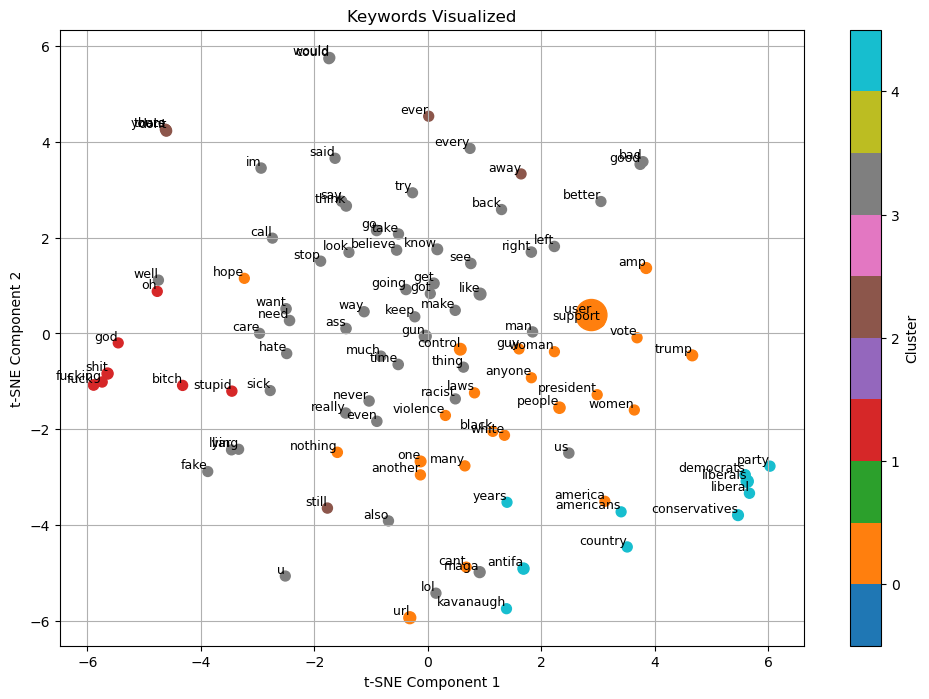

In [109]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

top_words = get_top_words(undetected_hate, 100)
words = list(set(top_words.keys()))

plot_clusters(top_words, words, tokenizer, bert_model, 5)

Common misclassified in top-100: 75

Clusters:
Cluster 2: ['maga', 'better', 'right', 'years', 'well', 'good', 'kavanaugh', 'antifa']
Cluster 3: ['left', 'take', 'care', 'keep', 'president', 'man', 'laws', 'thing', 'believe', 'see', 'make', 'user', 'gun', 'support', 'going', 'trump', 'amp', 'vote', 'one', 'hope', 'control', 'got', 'get', 'anyone', 'know']
Cluster 4: ['think', 'god', 'dont', 'lol', 'u', 'thats', 'way', 'could', 'im', 'say', 'cant', 'want', 'need', 'said', 'stop', 'go', 'url', 'look']
Cluster 0: ['country', 'party', 'conservatives', 'liberal', 'liberals', 'democrats']
Cluster 1: ['ever', 'nothing', 'another', 'much', 'like', 'people', 'back', 'us', 'would', 'also', 'never', 'still', 'really', 'every', 'america', 'many', 'even', 'time']


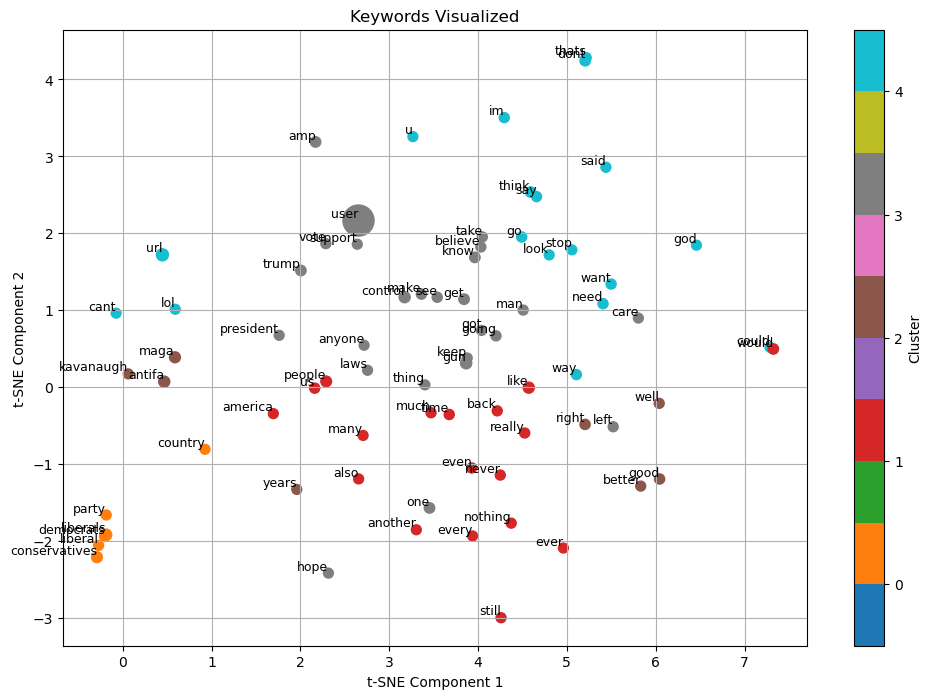

In [110]:
k = 100
top_misclassified_normal = get_top_words(misclassified_normal, k)
top_undetected_hate = get_top_words(undetected_hate, k)

common_misclassified_dict = {}
common_misclassified = top_misclassified_normal.keys() & top_undetected_hate.keys()
for word in common_misclassified:
    common_misclassified_dict[word] = top_misclassified_normal[word] + top_undetected_hate[word]
print(f'Common misclassified in top-{k}: {len(common_misclassified)}')

plot_clusters(common_misclassified_dict, list(common_misclassified), tokenizer, bert_model, 5)

# Implicit Hate dataset: Zero & Few-Shot

We are going to repeat the procedure for the implicit hate speech dataset, however, we are going to later see whether exact categories got misclassified more often than others. Our hypothesis is that irony will be misclassified more often than other implicit hate speech categories.

In [29]:
model = "vicuna"
dataset = "implicit_hate.json"

In [30]:
implicit_results = pd.read_json('results/' + model + '/' + dataset)

# This dataset will be cleaned
implicit_results_copy = implicit_results.copy(deep=True)

In [31]:
if model != 'hatebert':
    implicit_results['predicted_label'] = implicit_results['predicted_label'].str.replace(r'\D', '', regex=True)
    implicit_results['label'] = implicit_results['label'].apply(safe_cast_to_int)
    implicit_results['predicted_label'] = implicit_results['predicted_label'].apply(safe_cast_to_int)
implicit_mismatched_rows = implicit_results[implicit_results['label'].astype(int) != implicit_results['predicted_label']]

implicit_mismatched_rows.head()

,text,class,implicit_class,extra_implicit_class,id,label,prompt,predicted_label
1,b.higher education is a part of european cult...,not_hate,None,None,2,0,Is the following text hate speech? Answer with...,10
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,None,None,3,0,Is the following text hate speech? Answer with...,10
3,is yasir qadhi a hate preacher for calling ch...,not_hate,None,None,4,0,Is the following text hate speech? Answer with...,10
4,"rt "" : how three million germans mass murder...",not_hate,None,None,5,0,Is the following text hate speech? Answer with...,10
5,"rt "" we were murdered graffiti in synagogues...",not_hate,None,None,6,0,Is the following text hate speech? Answer with...,10


In [32]:
implicit_failed_rows = implicit_mismatched_rows[implicit_mismatched_rows['predicted_label'] == 2]
implicit_misclassified_rows = implicit_mismatched_rows[implicit_mismatched_rows['predicted_label'] != 2]

print(f'Failed to classify {len(implicit_failed_rows)} data points.\nMisclassified {len(implicit_misclassified_rows)} data points.\nTotal failed or misclassified: {len(implicit_failed_rows) + len(implicit_misclassified_rows)} / {len(implicit_results)}')

Failed to classify 1078 data points.
Misclassified 15961 data points.
Total failed or misclassified: 17039 / 21482


In [33]:
if model != 'hatebert':
    implicit_results_copy['predicted_label'] = implicit_results_copy['predicted_label'].str.replace(r'\D+', '', regex=True)
    
    # Check how many cells have exactly one symbol and whether that one symbol is 1 or 0
    one_symbol_labels = implicit_results_copy[implicit_results_copy['predicted_label'].str.len() == 1]
    valid_rows_count= one_symbol_labels['predicted_label'].isin(['0', '1']).sum()
    
    print(f'Number of rows where only one digit symbol is predicted as a label: {len(one_symbol_labels)}')
    print(f'Number of the same rows where the label is also valid (0 or 1): {valid_rows_count}')

Number of rows where only one digit symbol is predicted as a label: 8843
Number of the same rows where the label is also valid (0 or 1): 8843


In [34]:
if model != 'hatebert':
    implicit_results_copy['predicted_label'] = implicit_results_copy['predicted_label'].apply(process_label)
    implicit_results_copy.head()

implicit_misclassified_clean_rows = implicit_results_copy[implicit_results_copy['label'] != implicit_results_copy['predicted_label']]

print(f'Now there are {len(implicit_misclassified_clean_rows)} misclassified rows instead of {len(implicit_misclassified_rows)}.')

Now there are 8670 misclassified rows instead of 15961.


In [35]:
accuracy, recall, precision, f1 = calculate_metrics(implicit_results_copy['label'], implicit_results_copy['predicted_label'])


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.4169
Recall: 0.5535
Accuracy: 0.5964
F1 Score: 0.4756


In [36]:
implicit_misclassified_normal = implicit_misclassified_clean_rows[implicit_misclassified_clean_rows['predicted_label'] == 1] # Normal speech mistaken for hate
implicit_undetected_hate = implicit_misclassified_clean_rows[implicit_misclassified_clean_rows['predicted_label'] == 0] # Hate mistaken for normal speech

print(f'Misclassified as hate speech: {len(implicit_misclassified_normal)}\nMisclassified as normal: {len(implicit_undetected_hate)}')

Misclassified as hate speech: 5499
Misclassified as normal: 3171


Now, apply clustering again to see if there are any groups of keywords that can be detected.


Clusters:
Cluster 0: ['american', 'country', 'new', 'crime', 'antifa', 'americans', 'whites', 'nonwhite', 'blacks', 'muslim', 'jewish', 'video', 'obama', 'race', 'people', 'antiwhite', 'africa', 'illegal', 'islam', 'immigrants', 'state', 'illegals', 'genocide', 'immigration', 'media', 'jews', 'altright', 'children', 'supremacist', 'america', 'muslims']
Cluster 1: ['white', 'thing', 'come', 'let', 'would', 'im', 'better', 'need', 'trump', 'end', 'think', 'hate', 'well', 'black', 'see', 'way', 'good', 'must', 'support', 'say', 'every', 'still', 'world', 'racist', 'via', 'love', 'go', 'look', 'take', 'time', 'theyre', 'right', 'identity', 'south', 'says', 'guy', 'kill', 'yes', 'like', 'matter', 'us', 'back', 'call', 'also', 'cant', 'going', 'rt', 'one', 'many', 'know', 'man', 'dont', 'another', 'read', 'u', 'thats', 'youre', 'make', 'want', 'jew', 'never', 'isnt', 'really', 'stop', 'get', 'even']
Cluster 2: ['women', 'cities', 'men']


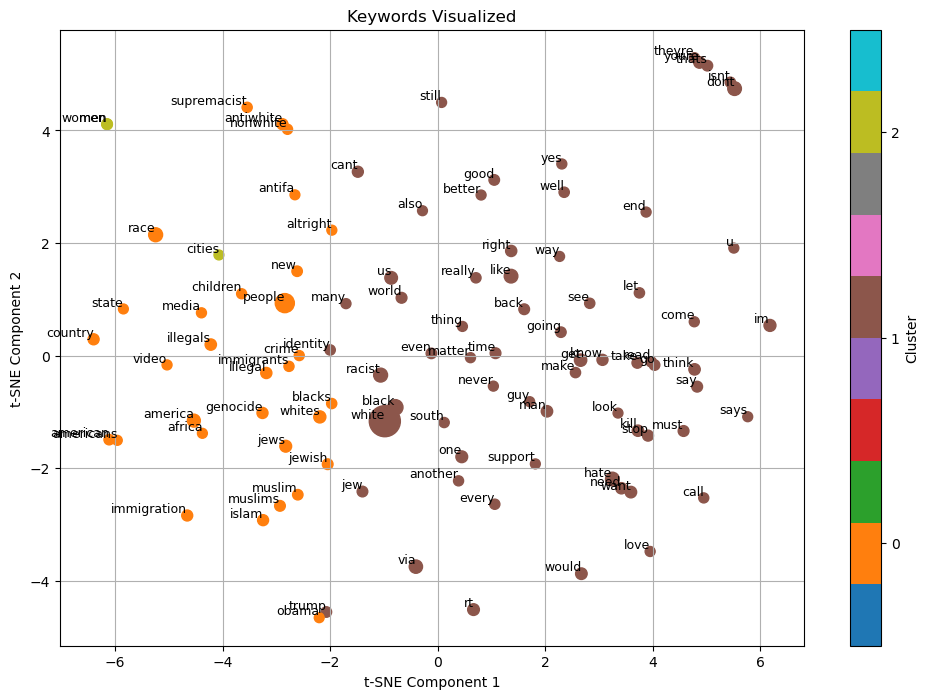

In [37]:
implicit_top_words = get_top_words(implicit_undetected_hate, 100)
implicit_words = list(set(implicit_top_words.keys()))

plot_clusters(implicit_top_words, implicit_words, tokenizer, bert_model, 3)

Common misclassified in top-100: 60

Clusters:
Cluster 1: ['media', 'muslim', 'antifa', 'many', 'law', 'islam', 'america', 'supremacist', 'jews', 'obama', 'blacks', 'people', 'immigration', 'muslims', 'american', 'whites']
Cluster 0: ['well', 'read', 'us', 'kill', 'cant', 'nothing', 'make', 'new', 'trump', 'go', 'right', 'hate', 'even', 'like', 'say', 'one', 'youre', 'way', 'think', 'see', 'rt', 'white', 'really', 'thats', 'dont', 'support', 'want', 'know', 'black', 'identity', 'would', 'racist', 'im', 'never', 'race', 'need', 'time', 'get', 'south', 'man', 'great', 'good', 'going']
Cluster 2: ['via']


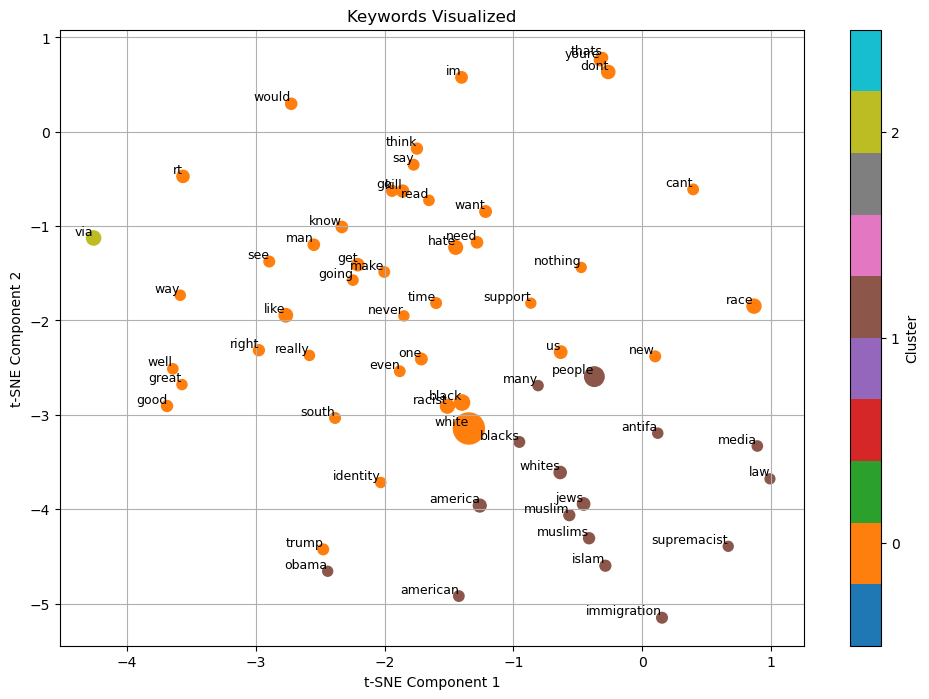

In [171]:
k = 100
implicit_top_misclassified_normal = get_top_words(implicit_misclassified_normal, k)
implicit_top_undetected_hate = get_top_words(implicit_undetected_hate, k)

implicit_common_misclassified_dict = {}
implicit_common_misclassified = implicit_top_misclassified_normal.keys() & implicit_top_undetected_hate.keys()
for word in implicit_common_misclassified:
    implicit_common_misclassified_dict[word] = implicit_top_misclassified_normal[word] + implicit_top_undetected_hate[word]
print(f'Common misclassified in top-{k}: {len(implicit_common_misclassified)}')

plot_clusters(implicit_common_misclassified_dict, list(implicit_common_misclassified), tokenizer, bert_model, 3)

Now let's dig deeper into mismatched categories.

In [172]:
original_implicit = pd.read_json('results/' + model + '/' + dataset)
original_counts = original_implicit.groupby('implicit_class').size().to_frame(name='counts')
mismatch_counts = implicit_misclassified_clean_rows.groupby('implicit_class').size().to_frame(name='counts')

In [173]:
# See how much (percentage-wise) are the predicted categories from the original outcomes

merged_counts = pd.merge(original_counts, mismatch_counts, on='implicit_class', suffixes=('_original', '_mismatch')).reset_index('implicit_class')
merged_counts['mismatch_percentage'] = merged_counts['counts_mismatch'] / merged_counts['counts_original'] * 100
merged_counts['mismatch_percentage'] = merged_counts['mismatch_percentage'].apply(lambda x: math.floor(x * 100) / 100)

merged_counts

,implicit_class,counts_original,counts_mismatch,mismatch_percentage
0,incitement,1240,1047,84.43
1,inferiority,861,739,85.83
2,irony,795,675,84.90
3,other,79,67,84.81
4,stereotypical,1105,870,78.73
5,threatening,666,608,91.29
6,white_grievance,1507,1249,82.87


# Mixed Irony: Zero & Few-shot

Now we will assess the models' performance on the mixed irony dataset which we created by mixing regular irony/sarcasm, unoffensive tweets, and offensive tweets with implicit hate speech categories from LatentHatred dataset.

In [56]:
model = 'vicuna'
dataset = 'mixed_irony.json'

In [57]:
mixed_results = pd.read_json('results/' + model + '/' + dataset)

# This dataset will be cleaned
mixed_results_copy = mixed_results.copy(deep=True)

mixed_results.head()

,text,post_id,id,class,label,prompt,predicted_label
0,#rx #drugs Too many Fiorinal - I'm an 18 year ...,47838,26599,regular,0,Is the following text hate speech? Answer with...,1
1,#Stephen #Colbert #officially takes over #CBS ...,52012,30773,regular,0,Is the following text hate speech? Answer with...,0\n### Human: Is the following text hate speec...
2,"""Send one #positive message, one #happy though...",43936,22697,regular,0,Is the following text hate speech? Answer with...,0\n### Human: Is the following text hate speec...
3,@Farnell_Simmys @fionagraham13 @tibberdog @str...,43978,22739,regular,0,Is the following text hate speech? Answer with...,"1\n\nText: ""I think all Muslims are terrorists"
4,"Wherever you find understanding, you find stre...",59642,38403,regular,0,Is the following text hate speech? Answer with...,"1\n\nText: ""I think all Muslims should be bann..."


In [58]:
print(mixed_results.groupby('class').size().to_frame(name='class_counts'))
print(f'\nTotal number of datapoints is {len(mixed_results)}')

               class_counts
class                      
hateful_irony           795
regular                 795
regular_irony           795

Total number of datapoints is 2385


Let's clean the results before checking whish labels are misclassified.

In [59]:
if model != 'hatebert':
    mixed_results['predicted_label'] = mixed_results['predicted_label'].str.replace(r'\D', '', regex=True)
    mixed_results['label'] = mixed_results['label'].apply(safe_cast_to_int)
    mixed_results['predicted_label'] = mixed_results['predicted_label'].apply(safe_cast_to_int)
mixed_mismatched_rows = mixed_results[mixed_results['label'].astype(int) != mixed_results['predicted_label']]

mixed_mismatched_rows.head()

,text,post_id,id,class,label,prompt,predicted_label
0,#rx #drugs Too many Fiorinal - I'm an 18 year ...,47838,26599,regular,0,Is the following text hate speech? Answer with...,1
1,#Stephen #Colbert #officially takes over #CBS ...,52012,30773,regular,0,Is the following text hate speech? Answer with...,10
2,"""Send one #positive message, one #happy though...",43936,22697,regular,0,Is the following text hate speech? Answer with...,10
3,@Farnell_Simmys @fionagraham13 @tibberdog @str...,43978,22739,regular,0,Is the following text hate speech? Answer with...,1
4,"Wherever you find understanding, you find stre...",59642,38403,regular,0,Is the following text hate speech? Answer with...,1


In [60]:
mixed_failed_rows = mixed_mismatched_rows[mixed_mismatched_rows['predicted_label'] == 2]
mixed_misclassified_rows = mixed_mismatched_rows[mixed_mismatched_rows['predicted_label'] != 2]

print(f'Failed to classify {len(mixed_failed_rows)} data points.\nMisclassified {len(mixed_misclassified_rows)} data points.\nTotal failed or misclassified: {len(mixed_failed_rows) + len(mixed_misclassified_rows)} / {len(mixed_results)}')

Failed to classify 160 data points.
Misclassified 1602 data points.
Total failed or misclassified: 1762 / 2385


In [61]:
if model != 'hatebert':
    mixed_results_copy['predicted_label'] = mixed_results_copy['predicted_label'].str.replace(r'\D+', '', regex=True)
    
    # Check how many cells have exactly one symbol and whether that one symbol is 1 or 0
    one_symbol_labels = mixed_results_copy[mixed_results_copy['predicted_label'].str.len() == 1]
    valid_rows_count= one_symbol_labels['predicted_label'].isin(['0', '1']).sum()
    
    print(f'Number of rows where only one digit symbol is predicted as a label: {len(one_symbol_labels)}')
    print(f'Number of the same rows where the label is also valid (0 or 1): {valid_rows_count}')

Number of rows where only one digit symbol is predicted as a label: 1130
Number of the same rows where the label is also valid (0 or 1): 1130


In [62]:
if model != 'hatebert':
    mixed_results_copy['predicted_label'] = mixed_results_copy['predicted_label'].apply(process_label)
    mixed_results_copy.head()

mixed_misclassified_clean_rows = mixed_results_copy[mixed_results_copy['label'] != mixed_results_copy['predicted_label']]

print(f'Now there are {len(mixed_misclassified_clean_rows)} misclassified rows instead of {len(mixed_misclassified_rows)}.')

Now there are 1126 misclassified rows instead of 1602.


In [63]:
accuracy, recall, precision, f1 = calculate_metrics(mixed_results_copy['label'], mixed_results_copy['predicted_label'])


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6719
Recall: 0.5704
Accuracy: 0.5279
F1 Score: 0.6170


Now we can check, how many labels got misclassified per each category: regular, hateful_irony and non_hateful irony.

In [55]:
mixed_results_copy['mismatch'] = mixed_results_copy['label'] != mixed_results_copy['predicted_label']

misclassified_counts = mixed_results_copy[mixed_results_copy['mismatch']].groupby('class').size().reset_index(name='misclassified_count')
misclassified_counts['original_count'] = list(mixed_results_copy.groupby('class').size())
misclassified_counts['percentage'] = misclassified_counts['misclassified_count'] / misclassified_counts['original_count'] * 100
misclassified_counts['percentage'] = misclassified_counts['percentage'].apply(lambda x: math.floor(x * 100) / 100)

misclassified_counts

,class,misclassified_count,original_count,percentage
0,hateful_irony,138,795,17.35
1,regular,577,795,72.57
2,regular_irony,164,795,20.62


# Appendix for additional plots

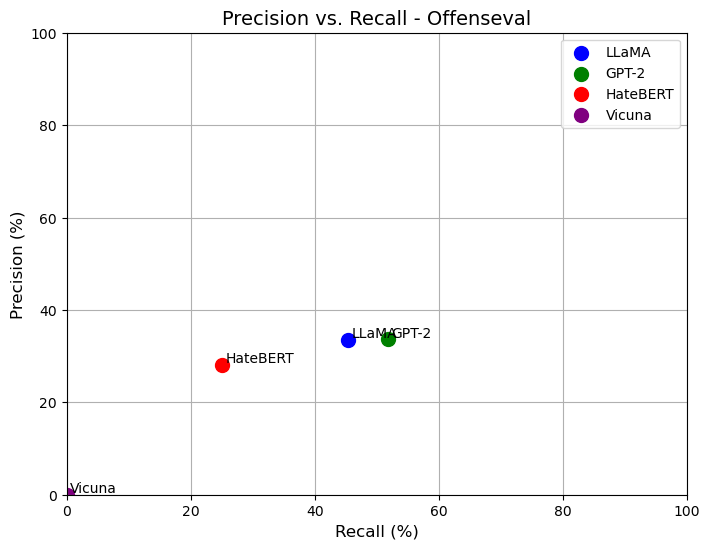

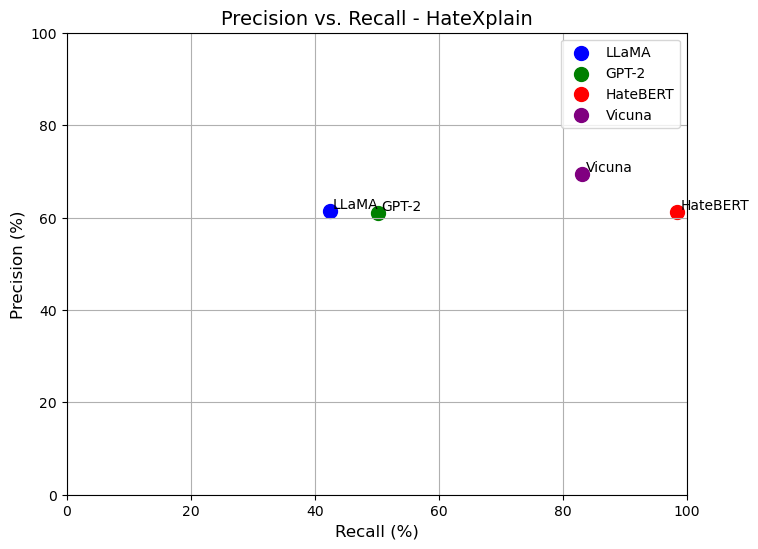

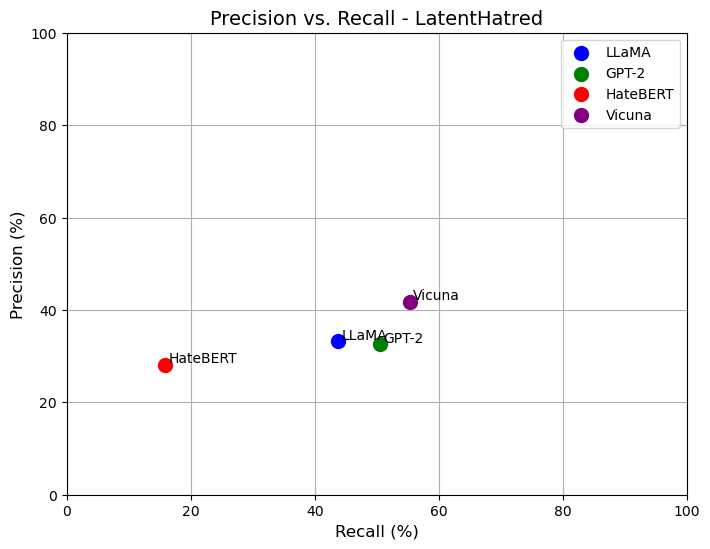

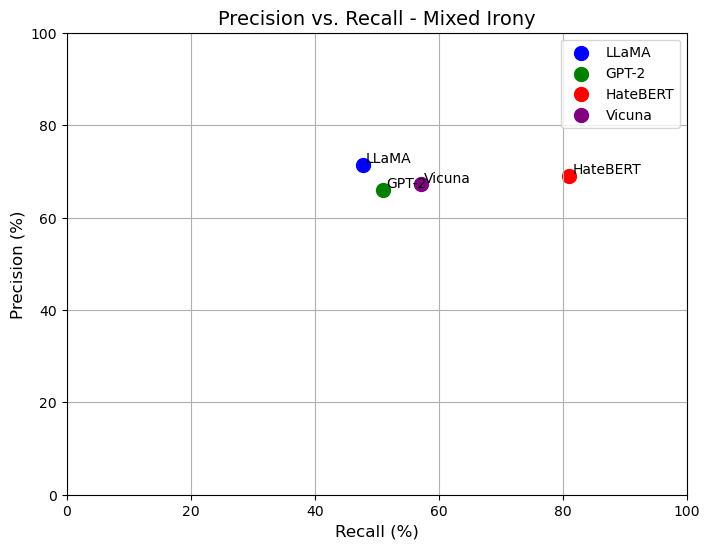

In [66]:
datasets = ['Offenseval', 'HateXplain', 'LatentHatred', 'Mixed Irony']
models = ['LLaMA', 'GPT-2', 'HateBERT', 'Vicuna']

metrics = {
    'Offenseval': {
        'LLaMA': {'Precision': 33.47, 'Recall': 45.41},
        'GPT-2': {'Precision': 33.65, 'Recall': 51.86},
        'HateBERT': {'Precision': 28.04, 'Recall': 25.05},
        'Vicuna': {'Precision': 0.00, 'Recall': 0.00},
    },
    'HateXplain': {
        'LLaMA': {'Precision': 61.50, 'Recall': 42.41},
        'GPT-2': {'Precision': 60.96, 'Recall': 50.18},
        'HateBERT': {'Precision': 61.19, 'Recall': 98.42},
        'Vicuna': {'Precision': 69.49, 'Recall': 83.14},
    },
    'LatentHatred': {
        'LLaMA': {'Precision': 33.21, 'Recall': 43.78},
        'GPT-2': {'Precision': 32.53, 'Recall': 50.51},
        'HateBERT': {'Precision': 28.15, 'Recall': 15.84},
        'Vicuna': {'Precision': 41.69, 'Recall': 55.35},
    },
    'Mixed Irony': {
        'LLaMA': {'Precision': 71.33, 'Recall': 47.74},
        'GPT-2': {'Precision': 65.95, 'Recall': 51.02},
        'HateBERT': {'Precision': 69.06, 'Recall': 81.01},
        'Vicuna': {'Precision': 67.19, 'Recall': 57.04},
    },
}

# Plotting

colors = {
    'LLaMA': 'blue',
    'GPT-2': 'green',
    'HateBERT': 'red',
    'Vicuna': 'purple',
}

for dataset in datasets:
    plt.figure(figsize=(8, 6))
    for model in models:
        precision = metrics[dataset][model]['Precision']
        recall = metrics[dataset][model]['Recall']
        plt.scatter(recall, precision, label=model, color=colors[model], s=100)
        plt.text(recall + 0.5, precision + 0.5, model)
    plt.xlabel('Recall (%)', fontsize=12)
    plt.ylabel('Precision (%)', fontsize=12)
    plt.title(f'Precision vs. Recall - {dataset}', fontsize=14)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.show()


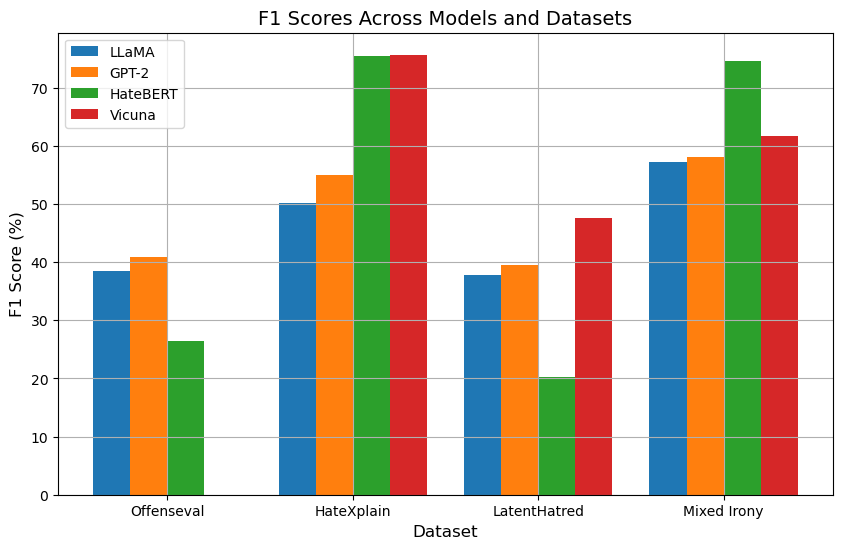

In [67]:
f1_scores = {
    'Offenseval': {'LLaMA': 38.54, 'GPT-2': 40.82, 'HateBERT': 26.46, 'Vicuna': 0.00},
    'HateXplain': {'LLaMA': 50.20, 'GPT-2': 55.05, 'HateBERT': 75.46, 'Vicuna': 75.70},
    'LatentHatred': {'LLaMA': 37.77, 'GPT-2': 39.57, 'HateBERT': 20.27, 'Vicuna': 47.56},
    'Mixed Irony': {'LLaMA': 57.20, 'GPT-2': 58.16, 'HateBERT': 74.56, 'Vicuna': 61.70},
}

datasets = list(f1_scores.keys())
models = ['LLaMA', 'GPT-2', 'HateBERT', 'Vicuna']
num_datasets = len(datasets)
bar_width = 0.2
index = np.arange(num_datasets)

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    scores = [f1_scores[dataset][model] for dataset in datasets]
    plt.bar(index + i * bar_width, scores, bar_width, label=model)

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('F1 Score (%)', fontsize=12)
plt.title('F1 Scores Across Models and Datasets', fontsize=14)
plt.xticks(index + bar_width * 1.5, datasets)
plt.legend()
plt.grid(True)
plt.show()
